In [ ]:
# !pip install 'qiskit[visualization]'
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime

In [2]:
import qiskit
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_distribution
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.classical import expr
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import math
import numpy as np
import matplotlib.pyplot as plt

### CHSH game

The CHSH game is a quantum mechanics experiment involving two players, Alice and Bob, who are separated. They receive binary inputs $x$ and $y$ (0 or 1) respectively and produce binary outputs $a$ and $b$.  The winning condition is described in the table below.

$ x \land y = a \oplus b $

| (x, y)    | winning condition |
| --------- | ----------------- |
| (0, 0)    | $a = b$           |
| (0, 1)    | $a = b$           |
| (1, 0)    | $a = b$           |
| (1, 1)    | $a \neq b$        |


In [20]:
def is_win(x, y, a, b):
    """
    x, y, a, b are 0 or 1
    return true if x and y = a xor b
    """
    if x==1 and y==1:
        if a != b:
            return True
        else:
            return False
    else:
        if a == b:
            return True
        else:
            return False

In [21]:
print("winning conditions")
print("x y a b")
for x in range(2):
    for y in range(2):
        for a in range(2):
            for b in range(2):
                if is_win(x, y, a, b):
                    print(x, y, a, b)

winning conditions
x y a b
0 0 0 0
0 0 1 1
0 1 0 0
0 1 1 1
1 0 0 0
1 0 1 1
1 1 0 1
1 1 1 0


While Alice and Bob cannot communicate, there is no strategy to win exceed 0.75 probability.

If Alice and Bob share an entangled qubit and allow to operate on their own qubit, the winning probability can reach 0.85.

### Share entangled qubit to reach 0.85 winning probability 

Consider

$ |\psi_{\theta} \rangle = \cos(\theta)|0\rangle + \sin(\theta)|1\rangle  $

Define

$ \operatorname{U}_{\theta} = |0\rangle \langle \psi_{\theta}| + |1\rangle \langle \psi_{\theta + \pi/2}| $

Effectively, $\operatorname{U}_\theta |\psi_\theta\rangle$ rotates $|\psi_\theta\rangle$ $2\theta$ to $|0\rangle$ and $\operatorname{U}_\theta |\psi_{\theta + \pi/2}\rangle$ rotates $|\psi_{\theta + \pi/2}\rangle$ $2\theta$ to $|1\rangle$.

$|\psi_\theta\rangle$ and $|\psi_{\theta + \pi/2}\rangle$ are visualized below.

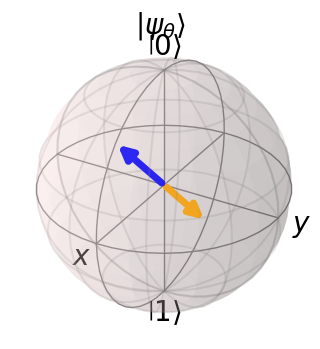

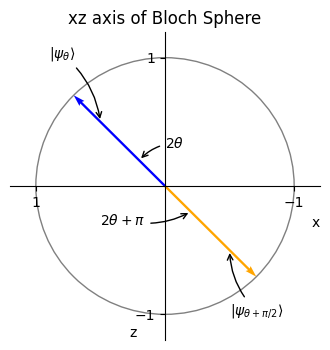

In [3]:
psi_axis = Bloch(figsize=(3, 3))
psi_axis.vector_color = ['blue', 'orange']
psi_axis.add_vectors([[1/math.sqrt(2), 0, 1/math.sqrt(2)], [-1/math.sqrt(2), 0, -1/math.sqrt(2)]])
psi_axis.render(title='$|\\psi_\\theta\\rangle$')

origin_x = origin_y = [0, 0]
direct_x = [1/math.sqrt(2), -1/math.sqrt(2)]
direct_y = [1/math.sqrt(2), -1/math.sqrt(2)]
fig, ax = plt.subplots(figsize=(4, 4))
plt.title('xz axis of Bloch Sphere')
plt.xlabel('x', loc='right')
plt.ylabel('z', loc='bottom', rotation=0)
ax.set_xlim(1.2, -1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.arange(1, -2, -2))
ax.set_yticks(np.arange(-1, 2, 2))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.quiver(origin_x, origin_y, direct_x, direct_y, color=['blue', 'orange'], angles='xy', scale_units='xy', scale=1)
ax.add_patch(plt.Circle((0, 0), 1, color='grey', fill=False))
plt.annotate('2$\\theta$', xy=(0.2, 0.2), xytext=(0, 0.3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate('$|\\psi_\\theta\\rangle$', xy=(0.5, 0.5), xytext=(0.9, 1), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.annotate('2$\\theta+\\pi$', xy=(-0.2, -0.2), xytext=(0.5, -0.3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate('$|\\psi_{\\theta + \\pi/2}\\rangle$', xy=(-0.5, -0.5), xytext=(-0.5, -1), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))

plt.show()

### Operation

Alice applies the following operator to her entangled qubit:

\begin{align*}
&\operatorname{U}_0 &\text{if } x=0           \\
&\operatorname{U}_{\pi/4} &\text{if } x=1
\end{align*}

Then, measure her qubit and use the value as $a$.

Bob applies the following operator to his entangled qubit:

\begin{align*}
&\operatorname{U}_{\pi/8} &\text{if } y=0           \\
&\operatorname{U}_{-\pi/8} &\text{if } y=1
\end{align*}

Then, measure his qubit and use the value as $b$.

### Implement $\operatorname{U}_{\theta}$

\begin{align*}
\operatorname{U}_{\theta} &=
\begin{bmatrix}
1 \\
0
\end{bmatrix}

\begin{bmatrix}
\cos(\theta) & \sin(\theta)
\end{bmatrix}

+

\begin{bmatrix}
0 \\
1
\end{bmatrix}

\begin{bmatrix}
\cos(\theta+\pi/2) & \sin(\theta+\pi/2)
\end{bmatrix}

\\

&=
\begin{bmatrix}
\cos(\theta) & \sin(\theta)             \\
\cos(\theta+\pi/2) & \sin(\theta+\pi/2)
\end{bmatrix}

\\ 

&=
\begin{bmatrix}
\cos(\theta) & \sin(\theta)             \\
-\sin(\theta) & \cos(\theta) 
\end{bmatrix}

\\

&=R_y(-2\theta)

\end{align*}

In [4]:
def create_gate_U(theta):
    m = [[np.cos(theta), np.sin(theta)],
         [np.cos(theta + np.pi/2), np.sin(theta + np.pi/2)]]
    return UnitaryGate(m, f'U {theta:.3f}')

### Example, $x=0, y=0$

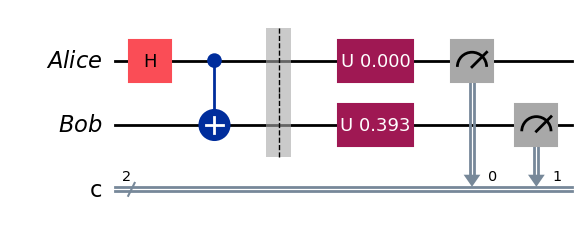

{'11': 460, '00': 414, '10': 62, '01': 88}
win probability =  0.853515625


In [ ]:
areg = QuantumRegister(1, "Alice")
breg = QuantumRegister(1, "Bob")
c = ClassicalRegister(2, "c")
qc = QuantumCircuit(areg, breg, c)
qc.h(areg)
qc.cx(areg, breg)
qc.barrier()
qc.append(create_gate_U(0), [areg[0]])
qc.append(create_gate_U(np.pi/8), [breg[0]])
qc.measure(areg, c[0])
qc.measure(breg, c[1])
display(qc.draw('mpl'))

sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc])
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print(samp_dist)
print("win probability = ", (samp_dist.get('00', 0) + samp_dist.get('11', 0))/sum(samp_dist.values()))

Measured value 'ba' = '00' and '11' are winning.  The probability is close to 0.85.  Notice the qiskit convention that 'ba' represents bit 0 as Alice and bit 1 as Bob.

### Simulate random inputs x, y

In [37]:
def get_win_prob(dist):
    count_win = 0
    count_loss = 0
    for k, v in dist.items():
        x = int(k[3]) # measured bit 0 is rightmost char [3] in string
        y = int(k[2])
        a = int(k[1])
        b = int(k[0])
        if is_win(x, y, a, b):
            count_win += v
        else:
            count_loss += v
    return count_win / (count_win + count_loss)

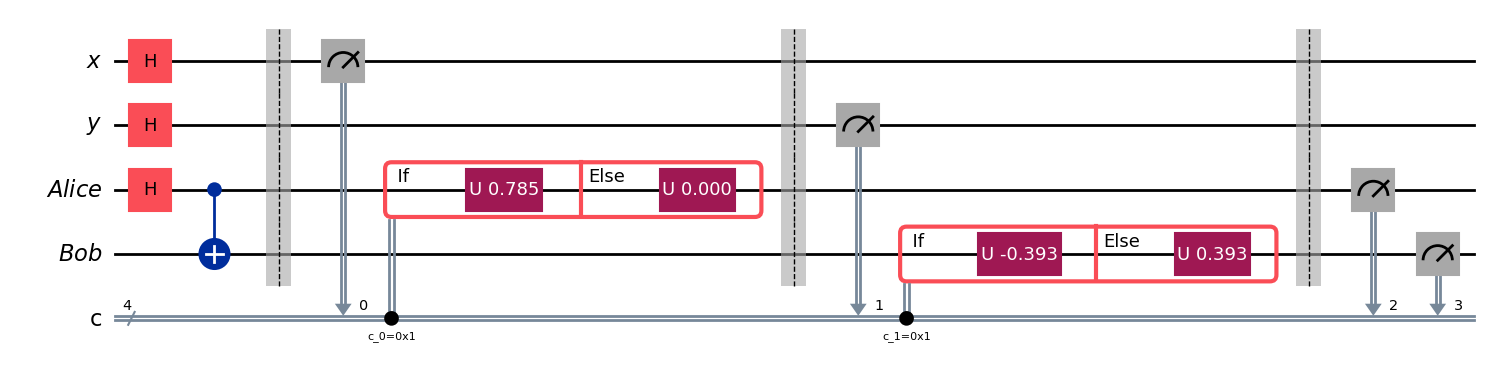

In [55]:
xreg = QuantumRegister(1, "x")
yreg = QuantumRegister(1, "y")
areg = QuantumRegister(1, "Alice")
breg = QuantumRegister(1, "Bob")
c_reg = ClassicalRegister(4, "c") # bit 0, 1, 2, 3 as x, y, a, b

qc = QuantumCircuit(xreg, yreg, areg, breg, c_reg)
qc.h(xreg)
qc.h(yreg)
qc.h(areg)
qc.cx(areg, breg)
qc.barrier()

# randomly generate x.  Apply Alice's operator accordingly
qc.measure(xreg, c_reg[0])
with qc.if_test((c_reg[0], 1)) as else_:
    qc.append(create_gate_U(np.pi/4), [areg])
with else_:
    qc.append(create_gate_U(0), [areg])
qc.barrier()

# randomly generate y.  Apply Bob's operator accordingly
qc.measure(yreg, c_reg[1])
with qc.if_test((c_reg[1], 1)) as else_:
    qc.append(create_gate_U(-np.pi/8), [breg])
with else_:
    qc.append(create_gate_U(np.pi/8), [breg])
qc.barrier()

# measure a, b
qc.measure(areg, c_reg[2])
qc.measure(breg, c_reg[3])
display(qc.draw('mpl'))

In [56]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc])
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print("sample distribution: ", samp_dist)
print("win probability = ", get_win_prob(samp_dist))

sample distribution:  {'1110': 100, '0011': 22, '0001': 120, '1001': 14, '0010': 109, '1100': 112, '0000': 112, '1011': 101, '0111': 96, '0110': 19, '1000': 11, '1101': 120, '1010': 17, '0100': 24, '0101': 26, '1111': 21}
win probability =  0.849609375


### Interpret the operation

As mentioned above, $\operatorname{U}_\theta$ rotates qubit $2\theta$ clockwise about y axis in Bloch sphere, i.e. $R_y(-2\theta)$.

Given an entangled qubit $|\Psi^+\rangle$, if one qubit is measured on computation base (i.e. $|0\rangle$, $|1\rangle$ base) and another is measured along $\pi/4$ apart (as orange vector below).  The probability of both measured as $|0\rangle$ can be simulated below.

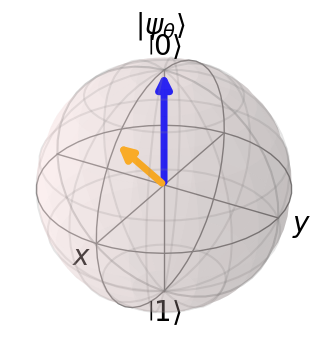

In [41]:
psi_axis = Bloch(figsize=(3, 3))
psi_axis.vector_color = ['blue', 'orange']
psi_axis.add_vectors([[0, 0, 1], [1/math.sqrt(2), 0, 1/math.sqrt(2)]])
psi_axis.render(title='$|\\psi_\\theta\\rangle$')

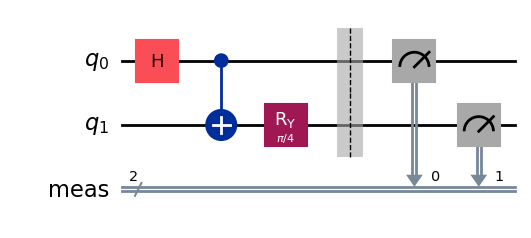

sample distribution:  {'00': 407, '01': 80, '11': 457, '10': 80}
measured the same probability =  0.84375


In [ ]:
qc2 = QuantumCircuit(2)
qc2.h(0)
qc2.cx(0, 1)
qc2.ry(-math.pi/4, 1) # effectively rotate the measured directly to |0> before measure
qc2.measure_all()
display(qc2.draw('mpl'))
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc2])
result = job.result()[0]
samp_dist = result.data.meas.get_counts()
print("sample distribution: ", samp_dist)
print("measured the same probability = ", (samp_dist.get('00', 0) + samp_dist.get('11', 0))/sum(samp_dist.values()))

The idea of Alice and Bob's operations is to put their measured directions satisfying conditions below.

1. if either of x or y is 0, their measured directions are relatively close such that their measured results are likely the same.
2. if both x and y are 1, their measure directions are relatively far away (between $\pi/2$ and $\pi$) such that their measured results are likely different.

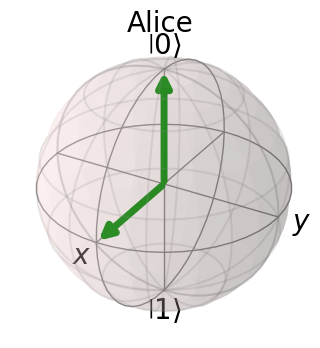

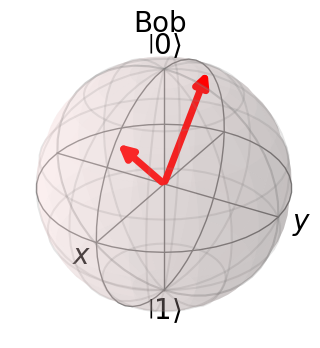

In [ ]:
alice_axis = Bloch(figsize=(3, 3))
alice_axis.vector_color = ['green']
alice_axis.add_vectors([[0, 0, 1], [1, 0, 0]])
alice_axis.render(title='Alice')

bob_axis = Bloch(figsize=(3, 3))
bob_axis.vector_color = ['red']
bob_axis.add_vectors([[-1/math.sqrt(2), 0, 1/math.sqrt(2)], [1/math.sqrt(2), 0, 1/math.sqrt(2)]])
bob_axis.render(title='Bob')

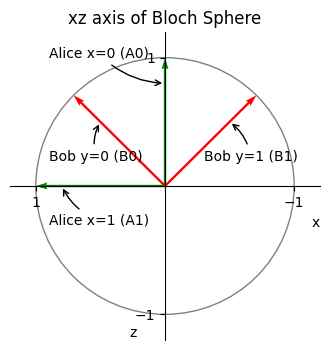

In [9]:
origin_x = origin_y = [0, 0, 0, 0]
direct_x = [-1/math.sqrt(2), 0, 1/math.sqrt(2), 1]
direct_y = [1/math.sqrt(2), 1, 1/math.sqrt(2), 0]
fig, ax = plt.subplots(figsize=(4, 4))
plt.title('xz axis of Bloch Sphere')
plt.xlabel('x', loc='right')
plt.ylabel('z', loc='bottom', rotation=0)
ax.set_xlim(1.2, -1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks(np.arange(1, -2, -2))
ax.set_yticks(np.arange(-1, 2, 2))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data', 0))
plt.quiver(origin_x, origin_y, direct_x, direct_y, color=['r', 'g', 'r', 'g'], angles='xy', scale_units='xy', scale=1)
ax.add_patch(plt.Circle((0, 0), 1, color='grey', fill=False))
plt.annotate('Alice x=0 (A0)', xy=(0, 0.8), xytext=(0.9, 1), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate('Alice x=1 (A1)', xy=(0.8, 0), xytext=(0.9, -0.3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.annotate('Bob y=0 (B0)', xy=(0.5, 0.5), xytext=(0.9, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"))
plt.annotate('Bob y=1 (B1)', xy=(-0.5, 0.5), xytext=(-0.3, 0.2), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

plt.show()

The above figure "xz axis of Bloch Sphere" shows the measured directions satisfying the conditions.

1. if either of x or y is 0, (A0, B0), (A0, B1) and (A1, B0) are $\pi/4$ apart.
2. if both x and y are 1, (A1, B1) are $3\pi/4$ apart.

The quantum circuit is revised to use QuantumCircuit.ry() instead of $\operatorname{U}_\theta$.

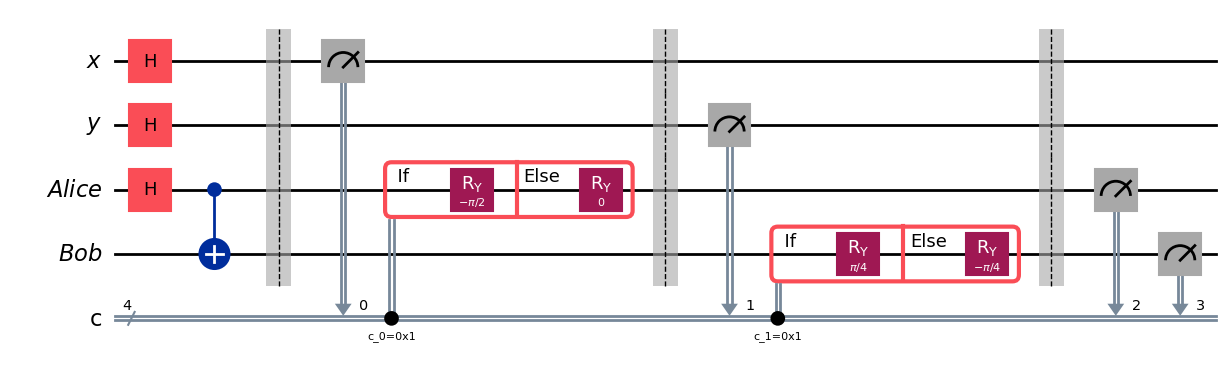

In [57]:
xreg = QuantumRegister(1, "x")
yreg = QuantumRegister(1, "y")
areg = QuantumRegister(1, "Alice")
breg = QuantumRegister(1, "Bob")
c_reg = ClassicalRegister(4, "c") # bit 0, 1, 2, 3 as x, y, a, b

qc = QuantumCircuit(xreg, yreg, areg, breg, c_reg)
qc.h(xreg)
qc.h(yreg)
qc.h(areg)
qc.cx(areg, breg)
qc.barrier()

# randomly generate x.  Apply Alice's operator accordingly.  Use ry()
qc.measure(xreg, c_reg[0])
with qc.if_test((c_reg[0], 1)) as else_:
    qc.ry(-math.pi/2, areg)
with else_:
    qc.ry(0, areg)
qc.barrier()

# randomly generate y.  Apply Bob's operator accordingly.  Use ry()
qc.measure(yreg, c_reg[1])
with qc.if_test((c_reg[1], 1)) as else_:
    qc.ry(math.pi/4, breg)
with else_:
    qc.ry(-math.pi/4, breg)
qc.barrier()

# measure a, b
qc.measure(areg, c_reg[2])
qc.measure(breg, c_reg[3])
display(qc.draw('mpl'))

In [58]:
sampler = Sampler(mode=AerSimulator())
job = sampler.run([qc])
result = job.result()[0]
samp_dist = result.data.c.get_counts()
print("sample distribution: ", samp_dist)
print("win probability = ", get_win_prob(samp_dist))

sample distribution:  {'0000': 99, '1011': 132, '0101': 16, '0111': 95, '0001': 119, '1100': 100, '1111': 20, '0110': 19, '1101': 109, '0010': 103, '1110': 118, '1000': 19, '0011': 19, '1001': 18, '1010': 20, '0100': 18}
win probability =  0.8544921875


In [54]:
qiskit.__version__

'1.4.0'